# Chapter11 離散値を取るパラメータを使う

Stan最大の弱点は離散パラメータを扱えないことである。その問題の解決策を説明する。基本的には、場合の数を数え上げて離散パラメータを消去した形で対数尤度を表現することで対処する。

## 11.1 離散パラメータを扱うテクニック

離散パラメータを消去した形で対数尤度を表現するには、以下の方法がある。
- target([4.3節参照](./chap04.ipynb#43-Stanのlp__とtarget))を使う方法
- 和の対数を安定かつ高速に計算するlog_sum_exp関数を使う方法

### 11.1.1 log_sum_exp関数

log_sum_exp関数は以下のように使う

```
log_sum_exp(引数, ...)
```

引数は複数のreal型変数や、vector型・row_vector型・matrix型・配列のいずれかを取ることもできる。


- real型変数を二つとる場合の使用例と定義
  ```
  log_sum_exp(real x, real y)
  ```
  $$
  \mathrm{\log\_sum\_exp}(x, y) = \log(\exp(x) + \exp(y))
  $$

- vector型変数をとる場合の使用例と定義
  ```
  log_sum_exp(vector x)
  ```
  $$
  \mathrm{\log\_sum\_exp}\left(\left(
    \begin{array}{c}
      x_1 \\ \vdots \\ x_K
    \end{array}
  \right)\right) = \log \left(\sum_{k=1}^K \exp(x_k) \right)
  $$

この右辺が、log sum of exponentials になっているのでlog_sum_exp関数。また$\exp(x_k)=u_k$と置き換えると以下の表現となる。

$$
\mathrm{\log\_sum\_exp}\left(\left(
\begin{array}{c}
    \log{u_1} \\ \vdots \\ \log{u_K}
\end{array}
\right)\right) = \log \left(\sum_{k=1}^K u_k \right)
$$

この式を右辺から左辺への変形と見ると、$\log$の引数である$\Sigma$(足し算)を左辺では$\Sigma$の各項の$\log$を取ったベクトルに変換している。これは、$u_k$のいずれかが小さい値の積(例えば$a_k, b_k$)である場合に、
- 右辺: $u_k = a_k \times b_k$

となる一方で、
- 左辺: $\log{u_k} = \log{(a_k \times b_k)} = \log{a_k} + \log{b_k}$

と和で計算できるため、数値計算が安定するというメリットがある。このため$\log$の引数に$\Sigma$がある場合によく使われるが、$\Sigma$の各項が正でなければ使えない点に注意。

### 11.1.2 周辺化消去

[9.5.1項](./chap09.ipynb#951)の説明にあるように、Stanではint型は宣言できない。そこでモデル式を変形し離散パラメータを消去する必要がある。その方法の一つとして、周辺化消去(summing out, marginalizing out)がある。具体的には、「場合の数をすべて数え上げて各々の場合の確率を算出して和をとることで、離散パラメータを消去する」という方法。以下に周辺化消去の例を二つ挙げる。

- ベルヌーイ分布に従う離散パラメータ(コイントス)
  ある高校に通う生徒を対象にした、喫煙したことがあるかのアンケートを考える。喫煙経験がある回答者もNoと答える場合があるだろう。そこで、回答者には隠れてコインを投げてもらい。表なら正直に回答してもらい、裏なら常にYesと回答してもらうとする。そして、100人分の回答データが得られたとする。
  
  \
  データファイル11.1 [data-coin.txt](chap11/input/data-coin.txt)
  - $Y=1$はYesで$Y=0$はNoと回答したことを表す。
  - コインの表が出る確率は0.5
  - このデータから生徒が喫煙する確率$q$を推定する
  
  \
  モデル式11-1
  $$
  \begin{align}
  coin[n] &\sim \mathrm{Bernoulli}(0.5) &n = 1, \ldots, N \nonumber \\
  \theta[1] &= q \nonumber \\
  \theta[2] &= 1.0 \nonumber \\
  Y[n] &\sim \mathrm{Bernoulli}(\theta[coin[n] + 1]) &n = 1, \ldots, N \nonumber \\
  \end{align}
  $$

  - $N$: アンケートに答えた人数
  - $n$: 生徒のインデックス
  - $coin[n]$: 表なら0、裏なら1を取る確率変数
  - $\theta$: 生徒が喫煙経験あり(Yes)と回答する確率。コインが表なら確率$\theta[1]=q$でYes、裏なら確率$\theta[2]=1.0$で(常に)Yes
  \
  このケースでは、$coin[n]$が離散パラメータ(int型)となる。ここでコイントスの「場合の数」を数え上げて和を取ることで、int型を消去する。

  ![図11.1](chap11/output/fig11-1.png)
  図11.1 一人にアンケートした場合の回答のメカニズム

  図11.1で示されるように、一人にアンケートを取った場合は、コインが表の場合と裏の場合の二通りがあり確率$p(y|q)$は両方の確率の和と等しい。これは以下の式で表され、この式は積分すると1となるため確率分布である。

  $$
  p(y|q) = 0.5 \times \mathrm{Bernoulli}(y|q) + 0.5 \times \mathrm{Bernoulli}(y|1.0)
  $$
  
  このように途中のコイントスの結果(離散パラメータ)を知らなくても裏と表の場合分けの確率が分かれば、最終的な確率が求められる。以上により一人にアンケートした場合の尤度は以下となる。

  $$
  p(Y|q) = 0.5 \times \mathrm{Bermoulli}(Y|q) + 0.5 \times \mathrm{Bernouli}(Y|1.0)
  $$

  この式をStanで実装するには対数をとって、対数尤度を求めて、targetを使った記法で足せばいい。対数尤度に前項のlog_sum_exp関数を使うと以下になる。

  $$
  \begin{align}
  \log p(Y|q) = \mathrm{log\_sum\_exp}(&\log{0.5} + \log{\mathrm{Bernoulli}(Y|q)}, \nonumber \\
  &\log{0.5} + \log{\mathrm{Bernoulli}(Y|1.0)}) \nonumber
  \end{align}
  $$

  Stanモデルの実装例[model11-1.stan](chap11/model/model11-1.stan)
  
  modelブロックが上式に対応している。$\log{\mathrm{Bernoulli}}$の代わりにbernoulli_lpmf関数を使用している。(lpmfはlog probability mass functionの略)

In [7]:
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル11-1の実行"""
coin_df = pl.read_csv("./chap11/input/data-coin.txt")

data = {
    "N": coin_df.shape[0],
    "Y": coin_df["Y"].to_list(),
}

sm = CmdStanModel(stan_file="./chap11/model/model11-1.stan")
fit = sm.sample(data=data, seed=1234)

fit.summary(percentiles=(2, 50, 97))

11:18:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:18:08 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,2%,50%,97%,N_Eff,N_Eff/s,R_hat
lp__,-69.761200,0.035153,0.938991,-72.600400,-69.399700,-69.080500,713.501,4459.38,1.00091
q,0.198501,0.003089,0.092628,0.026012,0.196153,0.378385,899.432,5621.45,1.00240


- ポアソン分布に従う離散パラメータ
  ここでは、喫煙のアンケートに対して単純なコイントスではなく以下の操作を行ったとする。
  1. 未知のパラメータ$\lambda$のポアソン分布から乱数を発生させる
  2. ポアソン分布から出力された値$m$の枚数のコインを一度に投げ、そのうち表が出た枚数を記録して$Y$とする
  3. この乱数を発生させて$Y$を記録する一連の動作を100回繰り返してデータを得る
  
  ここで、$Y$の最大値は9であった。また、コイントスで表が出る確率は0.5とし。このデータから$\lambda$を推定する。
  
  \
  データファイル11.2 [data-poisson-binomial.txt](chap11/input/data-poisson-binomial.txt)
  
  モデル式11-2
  $$
  \begin{align}
  m[n] &\sim \mathrm{Poisson}(\lambda) &n = 1, \ldots, N \nonumber \\
  Y[n] &\sim \mathrm{Binomial}(m[n], 0.5) &n = 1, \ldots, N \nonumber
  \end{align}
  $$

  ここで、$N$は記録の数、$n$はそのインデックス。n回目の試行時のコインの枚数$m[n]$は記録が残っていないため離散パラメータとなる。前の例のようにmの場合の数を数え上げて和を取って消去する。まずは一つ分の記録の尤度を考えると以下となる。右辺の各行が$m = 0, 1, 2, \ldots$の場合を表す。

  $$
  \begin{align}
  p(Y|\lambda) = &\mathrm{Poisson}(0|\lambda) \times \mathrm{Binomial}(Y|0, 0.5) + \nonumber \\
  &\mathrm{Poisson}(1|\lambda) \times \mathrm{Binomial}(Y|1, 0.5) + \nonumber \\
  &\mathrm{Poisson}(2|\lambda) \times \mathrm{Binomial}(Y|2, 0.5) + \nonumber \\
  &\cdots \nonumber
  \end{align}
  $$
  
  場合の数は無限個だが、ここで以下の2つの条件を考慮する
  1. $Y$の最大値は9なので、$m$については高々40までを考慮すればよい。\
  なぜなら$\mathrm{Binomial}(9|40, 0.5)$の場合は、$\mathrm{Binomial}(9|m, 0.5)$($m=12\sim25$くらいの場合)と比べ非常に小さいので[<sup>2)</sup>](#fn2)、$m \gt 40$の場合は無視してよい。
  2. $m \lt Y$の場合には$\mathrm{Binomial}(Y|m, 0.5)$は0となる
  
  \
  以上を整理すると、尤度は以下の式となる。
  $$
  p(Y|\lambda) = \sum_{m=Y}^{40}[\mathrm{Poisson}(m|\lambda) \times \mathrm{Binomial}(Y|m, 0.5)]
  $$

  実装に必要な対数尤度は、上式の対数を取ってlog_sum_exp関数を使う。
  $$
  \begin{align}
  \log{p(Y|\lambda)} &= \log{\left(\sum_{m=Y}^{40}[\mathrm{Poisson}(m|\lambda) \times \mathrm{Binomial}(Y|m, 0.5)] \right)} \nonumber \\
  &= \mathrm{log\_sum\_exp} \left(\left(
    \begin{array}{ll}
    \log{\mathrm{Poisson}(Y|\lambda)} & + \log{\mathrm{Binomial}(Y|Y, 0.5)} \\
    \log{\mathrm{Poisson}(Y+1|\lambda)} & + \log{\mathrm{Binomial}(Y|Y+1, 0.5)} \\ 
    &\vdots \\ 
    \log{\mathrm{Poisson}(40|\lambda)} & + \log{\mathrm{Binomial}(Y|40, 0.5)} \\ 
    \end{array}
  \right)\right) \nonumber \\
  \end{align}
  $$

  この対数尤度をN個の記録に拡張するには単純にfor文でN回繰り返す。

  \
  モデル式11-2の実装例 [model11-2.stan](chap11/model/model11-2.stan)

>[<sup>2)</sup>](#fn2-back) $\mathrm{Binomial}(9|40, 0.5)$は$2.5 \times 10^{-4}$ほど。Rではdbinom(9, size=40, prob=0.5)で計算できる。

In [10]:
from scipy.stats import binom

"""Binominal(9|40, 0.5)の検証"""
x, n, p = 9, 40, 0.5
binom.pmf(x, n, p)

for m in range(12, 26):
    print(f"Binominal({x}|{m}, {p})の確率は{binom.pmf(x, m, p):e}")  # noqa: T201

print(f"Binominal({x}|{n}, {p})の確率は{binom.pmf(x, n, p):e}")  # noqa: T201

Binominal(9|12, 0.5)の確率は5.371094e-02
Binominal(9|13, 0.5)の確率は8.728027e-02
Binominal(9|14, 0.5)の確率は1.221924e-01
Binominal(9|15, 0.5)の確率は1.527405e-01
Binominal(9|16, 0.5)の確率は1.745605e-01
Binominal(9|17, 0.5)の確率は1.854706e-01
Binominal(9|18, 0.5)の確率は1.854706e-01
Binominal(9|19, 0.5)の確率は1.761971e-01
Binominal(9|20, 0.5)の確率は1.601791e-01
Binominal(9|21, 0.5)の確率は1.401567e-01
Binominal(9|22, 0.5)の確率は1.185942e-01
Binominal(9|23, 0.5)の確率は9.741664e-02
Binominal(9|24, 0.5)の確率は7.793331e-02
Binominal(9|25, 0.5)の確率は6.088540e-02
Binominal(9|40, 0.5)の確率は2.486912e-04


In [12]:
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル式11-2の実行"""
poisson_binominal_df = pl.read_csv("./chap11/input/data-poisson-binomial.txt")

data = {
    "N": poisson_binominal_df.shape[0],
    "M_max": 40,
    "Y": poisson_binominal_df["Y"].to_list(),
}

sm = CmdStanModel(stan_file="./chap11/model/model11-2.stan")
fit = sm.sample(data=data, seed=1234)

fit.summary(percentiles=(2, 50, 97))

19:27:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:28:01 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,2%,50%,97%,N_Eff,N_Eff/s,R_hat
lp__,-211.9760,0.016077,0.680485,-214.14600,-211.7050,-211.4680,1791.54,427.372,1.00034
lambda,9.5832,0.011563,0.441039,8.70902,9.5731,10.4213,1454.77,347.035,1.00065


### 11.1.3 公式の活用

周辺化消去は、一般的に組み合わせ爆発などによって場合の数が非常に多くなるときは使えない。例えば前項の「ポアソン分布に従う離散パラメータ」の例題でいうと、データYの最大値が9よりもっと大きな値の場合には、mについて非常に大きな値を考慮する必要があり、現実的な時間内に推定できない。しかし、公式の活用によって離散パラメータを消去できることがしばしばある。実は前項の「ポアソン分布に従う離散パラメータ」の例題もその一例である。モデル式は以下となる。

モデル式11-3
$$
\begin{align}
m &\sim \mathrm{Poisson}(\lambda) \nonumber \\
Y &\sim \mathrm{Biromial}(m, p) \nonumber
\end{align}
$$
このモデル式はmを消去して以下のように書き直す事ができる。

モデル式11-4
$$
Y \sim \mathrm{Poisson}(\lambda p)
$$
以下は証明。
$$
\begin{align}
  &\sum_{m=0}^{\infty} [\mathrm{Poisson}(m|\lambda) \times \mathrm{Binomial}(Y|m, p)] \nonumber \\
= &\sum_{m=Y}^{\infty} \left[ \frac{\lambda^{m} e^{-\lambda}}{m!} \times \frac{m!}{Y! (m-Y)!}p^{Y} (1 - p)^{m - Y} \right] \nonumber \\
= &\frac{p^{Y} e^{-\lambda}}{Y!} \sum_{m=Y}^{\infty} \left[\frac{\lambda^{m}}{(m-Y)!}(1-p)^{m-Y}\right] \nonumber \\
= &\frac{p^{Y} e^{-\lambda}}{Y!} \sum_{\xi=0}^{\infty} \left[\frac{\lambda^{\xi+Y}}{\xi!} (1-p)^{\xi} \right]
=  \frac{(\lambda p)^{Y} e^{-\lambda}}{Y!} \sum_{\xi=0}^{\infty} \left[\frac{\lambda^{\xi}}{\xi!} (1 - p)^{\xi} \right] \nonumber \\
= &\frac{(\lambda p)^{Y} e^{-\lambda}}{Y!} e^{\lambda(1 - p)}
=  \frac{(\lambda p)^{Y} e^{-(\lambda p)}}{Y!} \nonumber
\end{align}
$$

この公式を使ってモデル式11-2を実装すると、以下となる。

[model11-2b.stan](chap11/model/model11-2b.stan)


人口などの離散値を扱う場合には有限とはいえ場合の数が多く，Stanでは現実的に実行不可能なことがある。そのような場合には、例えば二項分布やポアソン分布を正規分布などの連続値を生成する分布で近似する選択肢もある。

In [14]:
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル式11-2aの実行"""
poisson_binominal_df = pl.read_csv("./chap11/input/data-poisson-binomial.txt")

data = {
    "N": poisson_binominal_df.shape[0],
    "Y": poisson_binominal_df["Y"].to_list(),
}

sm = CmdStanModel(stan_file="./chap11/model/model11-2b.stan")
fit = sm.sample(data=data, seed=1234)

fit.summary(percentiles=(2, 50, 97))

20:24:03 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-2b.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-2b
20:24:07 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-2b
20:24:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:24:07 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,2%,50%,97%,N_Eff,N_Eff/s,R_hat
lp__,273.12900,0.016023,0.699633,270.84400,273.40300,273.6280,1906.52,30262.2,0.999978
lambda,9.59054,0.011741,0.437853,8.71781,9.57441,10.4172,1390.80,22076.2,1.003680


## 11.2 混合正規分布

この節では架空の会社における、社員の能力測定の結果である実数値Scoreのデータを扱う。

データファイル11.3 [data-mix1.txt](chap11/input/data-mix1.txt)

データ(100人)はScoreの低い怠け者グループと、Scoreの高いがんばりやグループの二つのグループで構成されている事がわかっているとする。実際にY列の値のヒストグラムとkdeを重ねると図11.2となり、二つの正規分布を混ぜた混合正規分布が見られる。

混合正規分布は確率$a$で1つ目の正規分布から生成され、確率$1-a$で2つ目の正規分布から生成されたと考える分布。

$$
\mathrm{Normal\_Mixture}(y|a,\mu_1, \mu_2, \sigma_1, \sigma_2) = a \times \mathrm{N}(y|\mu_1,\sigma_1) + (1 - a) \times \mathrm{N}(y|\mu_2,\sigma_2)
$$

この式は(11.2)式([11.1.2項参照](#1112-周辺化消去))の0.5が$a$になり、ベルヌーイ分布が正規分布に変わったもの。
$$
p(y|q) = 0.5 \times \mathrm{Bernoulli}(y|q) + 0.5 \times \mathrm{Bernoulli}(y|1.0)
$$

混合正規分布を使ってモデル式にすると以下になる。

モデル式11-5
$$
Y[n] \sim \mathrm{Normal\_Mixture}(a, \mu_1, \mu_2, \sigma_1, \sigma_2) \qquad n=1, \ldots, N
$$

- $N$: 社員の人数
- $n$: 社員のインデックス
- データから$a, \mu_1, \mu_2, \sigma_1, \sigma_2$を推定する

実装例 [model11-5.stan](chap11/model/model11-5.stan)

[model11-1.stan](chap11/model/model11-1.stan)(ベルヌーイ分布の場合)とほぼ同じ。
- normal_ldpf(Y|mu, sigma)は$\log \mathrm{Normal}(Y|\mu, \sigma)$と等価
- log1m(a)関数はlog(1 - a)をより安定に計算するための便利な関数

[model11-5.stan](chap11/model/model11-5.stan)はmuとsigmaについてほぼ無情報であり、局所最適値を数多く持つモデルであるため、初期値によってはなかなか収束しない。

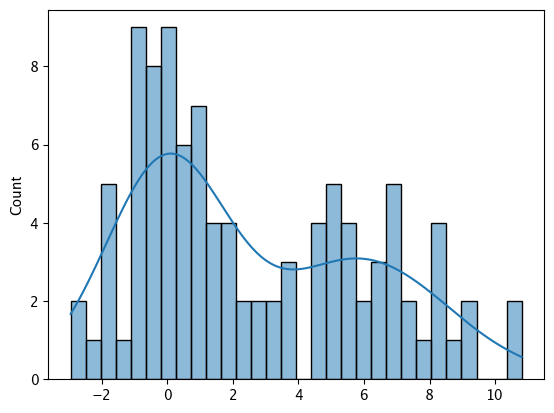

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

"""図11.2"""
mix1 = pl.read_csv("./chap11/input/data-mix1.txt")
sns.histplot(mix1["Y"], kde=True, bins=30)
plt.show()

In [40]:
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル式11-5実行例"""
data_mix1_df = pl.read_csv("./chap11/input/data-mix1.txt")

data = {
    "N": data_mix1_df.shape[0],
    "Y": data_mix1_df["Y"].to_list(),
}

sm = CmdStanModel(stan_file="./chap11/model/model11-5.stan")
fit = sm.sample(data=data, seed=1220)  # seed=1234だとパラメータがinfに発散する!
fit.summary(percentiles=(2, 50, 97))

21:49:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:49:10 - cmdstanpy - INFO - CmdStan done processing.
21:49:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-5.stan', line 14, column 4 to line 17, column 6)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-5.stan', line 14, column 4 to line 17, column 6)
Consider re-running with show_console=True if the above output is unclear!


,Mean,MCSE,StdDev,2%,50%,97%,N_Eff,N_Eff/s,R_hat
lp__,-248.328000,0.044923,1.698930,-252.814000,-247.977000,-246.123000,1430.28,3036.68,1.00324
a,0.542198,0.001750,0.075634,0.368863,0.546956,0.674460,1867.16,3964.24,1.00143
mu[1],-0.054055,0.004752,0.231717,-0.517069,-0.060391,0.404995,2378.19,5049.24,1.00093
mu[2],5.729340,0.016743,0.662781,4.164090,5.801520,6.796390,1567.02,3327.00,1.00206
sigma[1],1.292370,0.003962,0.186254,0.947665,1.277780,1.675480,2210.23,4692.63,1.00125
sigma[2],2.483140,0.011583,0.480602,1.678380,2.423340,3.522090,1721.63,3655.27,1.00206


次にK個の正規分布を混ぜた混合正規分布を使ってあてはめる場合を考える．ここでは別の社員200人分の実数値Scoreのデータを扱う。

データファイル11.4 [data-mix2.txt](chap11/input/data-mix2.txt)

先程と同様にY列の値のヒストグラムと密度関数を重ねて描くと図11.3となる。正規分布をK個混ぜた混合正規分布は以下になる。
$$
\mathrm{Normal\_Mixture}(y|\vec{a}, \vec{\mu}, \vec{\sigma}) = \sum_{k=1}^K a_k \mathrm{Normal}(y|\mu_k,\sigma_k)
$$

ここで$\vec{a}$の各要素は[0, 1]の範囲で合計すると1となる、つまり$\vec{a}$はsimplexである。この分布を使ってモデル式を書くと以下になる。

モデル式11-6
$$
Y[n] \sim \mathrm{Normal\_Mixture}(\vec{a}, \vec{\mu}, \vec{\sigma}) \qquad n = 1, \ldots, N
$$

実装に必要な対数尤度は上記の混合正規分布の対数をとってlog_sum_exp関数を使うと、以下となる。

$$
\begin{align}
\log{\mathrm{Normal\_Mixture}(y|\vec{a}, \vec{\mu}, \vec{\sigma})} = \log&{\left[\sum_{k=1}^K a_k \mathrm{Normal}(y|\mu_k, \sigma_k) \right]} \nonumber \\
= \mathrm{log\_sum\_exp} &\left[\left(
    \begin{array}{c}
      \log{\{a_1 \mathrm{Normal}(y|\mu_1, \sigma_1)\}} \\
      \vdots \\
      \log{\{a_k \mathrm{Normal}(y|\mu_k, \sigma_k)\}}
    \end{array}
\right)\right] \nonumber \\
= \mathrm{log\_sum\_exp} &\left[\left(
    \begin{array}{c}
      \log{\{a_1 + \mathrm{normal\_lpdf}(y|\mu_1, \sigma_1)\}} \\
      \vdots \\
      \log{\{a_k + \mathrm{normal\_lpdf}(y|\mu_k, \sigma_k)\}}
    \end{array}
\right)\right] \nonumber
\end{align}
$$

実装例 [model11-6.stan](chap11/model/model11-6.stan)

ここでは仮に混ざっている正規分布の個数$K=5$としたが、$K$を増やすと局所最適が増えMCMCが収束しにくくなる。

- functionsブロック
  functionsブロックでは、ユーザーが独自関数を定義できる。これを使うとmdoel11-6は以下のように書ける。

  [model11-6b.stan](chap11/model/model11-6b.stan)

  2行目で関数の名前とその引数と返値の型を定義している。6行目のreturn関数で値を返している。このコードのように「〇〇_Ipdf」(確率密度関数の場合)または「〇〇_lpmf」(確率質量関数の場合)という関数名にすると、「〇〇」という確率分布があらかじめStanに用意されているかのように使うことができる。modelブロックの18行目ではfunctionsブロックで定義した関数を使っている。18行目は内部的には、
  ```
  target += normal_mixture_lpdf(Y[n] | K, a, mu, sigma);
  ```
  と等価である。なお、functionsブロックはdataブロックよりも前に書くので、dataブロックで言する変数を使うことができない。関数の引数でvectorの長さ(ここではK)を渡すか、num_elements 関数・rows 関数・cols関数などで動的に長さを取得する必要がある。

  functionsブロックは柔軟性が高いが乱用すると可読性が落ちる。基本的にはこの節のように独自の確率分布を定義すると見通しがよくなる場合や、modelブロックやgenerated quantitiesブロックで同じコードを繰り返すのを避ける場合に限って使うとよいだろう。functionsブロックの他の応用例についてはStanのマニュアルの「User-Defined Functions」の章を参照。

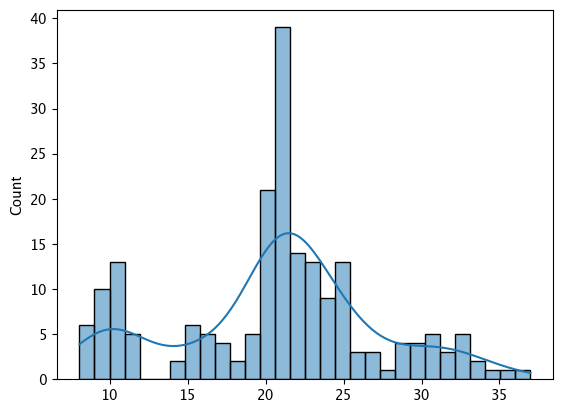

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

"""図11.3"""
mix2 = pl.read_csv("./chap11/input/data-mix2.txt")
sns.histplot(mix2["Y"], kde=True, bins=30)
plt.show()

In [46]:
import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel

""""""
mix2 = pl.read_csv("./chap11/input/data-mix2.txt")
K = 5
data = {
    "N": mix2.shape[0],
    "K": K,
    "Y": mix2["Y"].to_list(),
}
inits = {
    "a": np.full(K, 1 / K),
    "mu": np.linspace(10, 40, K),
    "sigma": np.ones(K),
    "s_mu": 20,
}


sm = CmdStanModel(stan_file="./chap11/model/model11-6.stan")
fit = sm.sample(data=data, inits=inits, seed=1234)
print(fit.summary(percentiles=(2, 50, 97)))  # noqa: T201

sm_b = CmdStanModel(stan_file="./chap11/model/model11-6b.stan")
fit_b = sm.sample(data=data, inits=inits, seed=1234)
print(fit_b.summary(percentiles=(2, 50, 97)))  # noqa: T201

22:23:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:23:43 - cmdstanpy - INFO - CmdStan done processing.
22:23:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[2] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-6.stan', line 16, column 2 to column 26)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-6.stan', line 20, column 6 to column 62)
Exception: gamma_lpdf: Random variable[2] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-6.stan', line 16, column 2 to column 26)
Exception: gamma_lpdf: Random variable[2] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-6.stan', line 16, column 2 to column 26)
Exception: gamma_lpdf: Random variable[2] is inf, but must


                Mean      MCSE    StdDev          2%         50%         97%  \
lp__     -601.443000  0.173164  3.560110 -611.050000 -600.841000 -596.304000   
a[1]        0.170401  0.000510  0.026988    0.119144    0.168612    0.225152   
a[2]        0.098768  0.001274  0.029738    0.052079    0.096336    0.151060   
a[3]        0.310798  0.002186  0.070603    0.173465    0.309388    0.443468   
a[4]        0.263431  0.003531  0.082312    0.101248    0.264238    0.419233   
a[5]        0.156603  0.002534  0.051442    0.090607    0.146401    0.295819   
mu[1]      10.013300  0.003273  0.177583    9.643780   10.011700   10.353100   
mu[2]      16.116900  0.033059  0.575308   15.322700   16.061900   17.159700   
mu[3]      20.874000  0.003001  0.139225   20.623600   20.860800   21.171900   
mu[4]      23.468600  0.022373  0.683832   22.095400   23.454300   24.692700   
mu[5]      30.741100  0.066822  1.318420   26.199300   31.077200   32.204800   
sigma[1]    0.981703  0.002208  0.12570

22:23:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:23:50 - cmdstanpy - INFO - CmdStan done processing.
22:23:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[2] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-6.stan', line 16, column 2 to column 26)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-6.stan', line 20, column 6 to column 62)
Exception: gamma_lpdf: Random variable[2] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-6.stan', line 16, column 2 to column 26)
Exception: gamma_lpdf: Random variable[2] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/model/model11-6.stan', line 16, column 2 to column 26)
Exception: gamma_lpdf: Random variable[2] is inf, but must


                Mean      MCSE    StdDev          2%         50%         97%  \
lp__     -601.443000  0.173164  3.560110 -611.050000 -600.841000 -596.304000   
a[1]        0.170401  0.000510  0.026988    0.119144    0.168612    0.225152   
a[2]        0.098768  0.001274  0.029738    0.052079    0.096336    0.151060   
a[3]        0.310798  0.002186  0.070603    0.173465    0.309388    0.443468   
a[4]        0.263431  0.003531  0.082312    0.101248    0.264238    0.419233   
a[5]        0.156603  0.002534  0.051442    0.090607    0.146401    0.295819   
mu[1]      10.013300  0.003273  0.177583    9.643780   10.011700   10.353100   
mu[2]      16.116900  0.033059  0.575308   15.322700   16.061900   17.159700   
mu[3]      20.874000  0.003001  0.139225   20.623600   20.860800   21.171900   
mu[4]      23.468600  0.022373  0.683832   22.095400   23.454300   24.692700   
mu[5]      30.741100  0.066822  1.318420   26.199300   31.077200   32.204800   
sigma[1]    0.981703  0.002208  0.12570

## 11.3 ゼロ過剰ポアソン分布

ある飲食店への来店回数をアンケートで取得した架空データを扱う。

データファイル11.5 [data-ZIP.txt](chap11/input/data-ZIP.txt)

それぞれの列の説明は以下である。
- $Sex$: 性別(0=男性、1=女性)
- $Sake$: お酒を飲むか(0=飲まない、1＝飲む)
- $Age$: 年齢
- $Y$: 来店回数(応答変数)

単純に重回帰してみる
またその予測分布を確認する

重回帰分析のレポートを見ると、Sexの係数が負の値、Sakeの係数が正の値、年齢が正の値になっているため、「男性でお酒を飲んで年齢が高い人の来店回数が多そうだ」という結果になった。しかし、決定係数が0.143と低い。また予測分布がマイナス値になるといった結果は現実と合わない。そこで[3.2節](./chap03.ipynb#32-)の統計モデリング手順に従って解析をやり直す。

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     10.91
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           1.16e-06
Time:                        10:51:59   Log-Likelihood:                -548.29
No. Observations:                 200   AIC:                             1105.
Df Residuals:                     196   BIC:                             1118.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2040      1.018      2.165      0.0

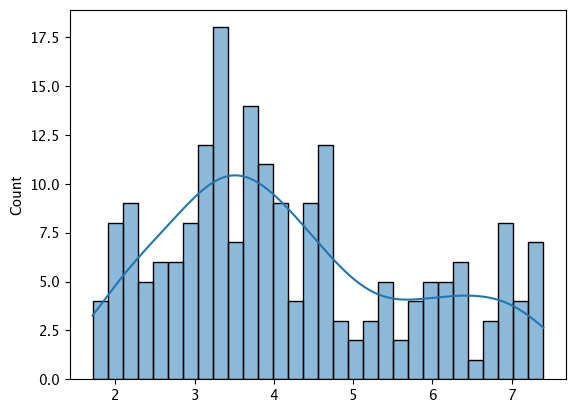

In [11]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import statsmodels.api as sm

"""重回帰"""

zip_df = pl.read_csv("./chap11/input//data-ZIP.txt")
X = zip_df.select(
    [
        pl.lit(1).alias("Intercept"),  # 切片項を追加
        pl.col("Sex"),
        pl.col("Sake"),
        pl.col("Age"),
    ],
)
Y = zip_df["Y"]

mod = sm.OLS(Y.to_pandas(), X.to_pandas())
result = mod.fit()
print(result.summary())  # noqa: T201

sns.histplot(result.fittedvalues, kde=True, bins=30)
plt.show()

### 11.3.1 解析の目的とデータの分布の確認

目的は以下の3つに設定する。
- リピーターになりそうな人を知りたい
- 説明変数でリピーターになるかをどれほど予測できるか知りたい
- それぞれの説明変数がリピーターになるかにどれほど影響しているか知りたい

データの分布を確認するために散布図行列を用いる(図11.4)

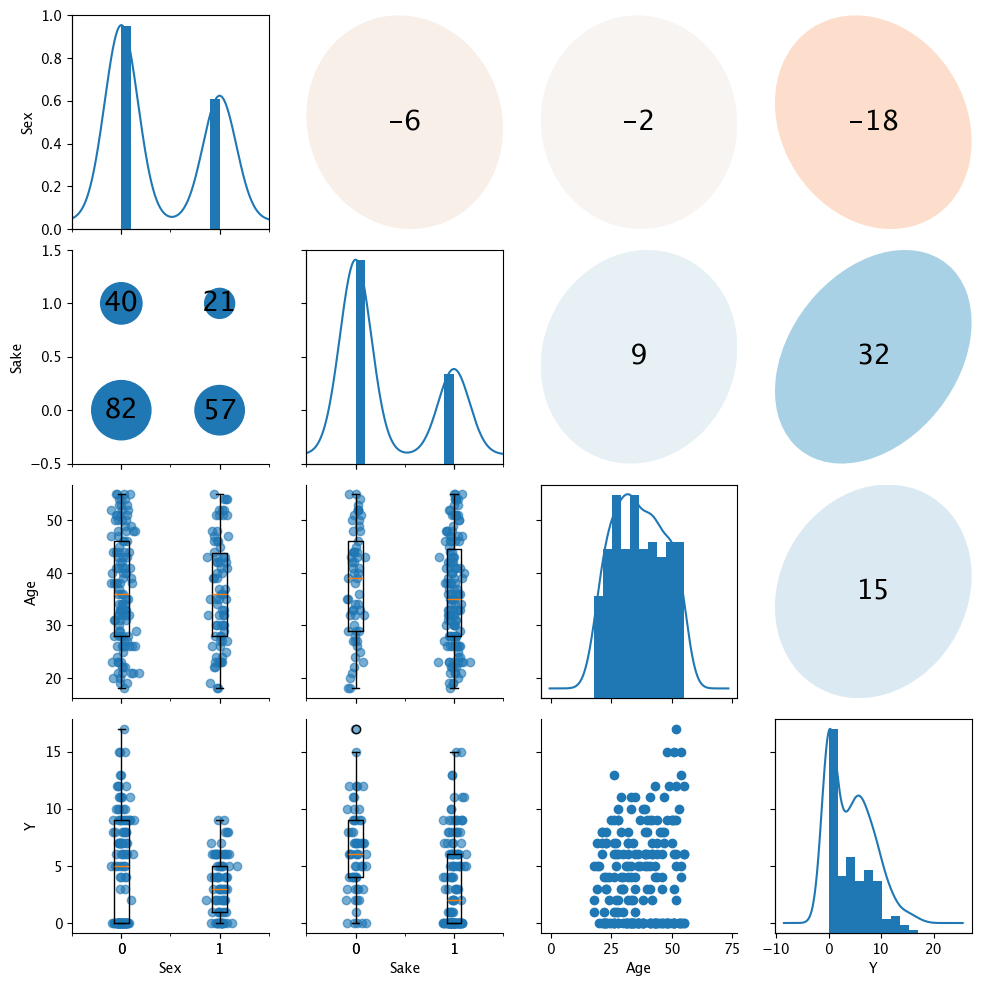

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

"""図11.4"""


class Dispatcher:
    def __init__(self, fontsize=20, alpha=0.6, cmap="RdBu", threshold=10):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)

        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold

    def comb(self, x_series, y_series, label=None, color=None):
        """下三角部分のプロット."""
        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label, color=color)

        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
            return self._dc_plot(x_series, y_series, label=label, color=color)

        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label, color=color)

    def _dd_plot(self, x_series, y_series, label=None, color=None):
        """離散値 x 離散値のプロット."""
        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.codes[0]
        yloc = total.index.codes[1]
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values, strict=False):
            ax.annotate(vp, (xp, yp), fontsize=self.fontsize, ha="center", va="center")

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label, color=color)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)

    def _dc_plot(self, x_series, y_series, label=None, color=None):
        """離散値 x 連続値のプロット."""
        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            x_series, y_series = y_series, x_series
            vert = False
        else:
            vert = True

        xlab, xun = pd.factorize(x_series)

        # 箱ひげ図用のデータの準備
        data = []
        for i, g in y_series.groupby(xlab):
            data.append(g)

        ax = plt.gca()
        ax.boxplot(data, positions=np.arange(len(data)), vert=vert)

        # 散布図をプロット
        xloc = xlab + np.random.normal(scale=0.05, size=len(xlab))
        if not vert:
            y_series, xloc = xloc, y_series

        ax.scatter(xloc, y_series, label=label, color=color, alpha=self.alpha)

    def diag(self, series, label=None, color=None):
        """対角部分のプロット."""
        ax = series.plot.hist()
        ax = series.plot.kde(grid=False, ax=ax.twinx())
        ax.yaxis.set_visible(False)

    def ellipse(self, x_series, y_series, label=None, color=None):
        """上三角部分のプロット."""
        from matplotlib.patches import Ellipse

        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))

        ax = plt.gca()
        ax.axis("off")
        ax.add_artist(
            Ellipse(
                xy=[0.5, 0.5],
                width=np.sqrt(1 + r),
                height=np.sqrt(1 - r),
                angle=45,
                facecolor=c,
                edgecolor="none",
                transform=ax.transAxes,
            ),
        )
        ax.text(
            0.5,
            0.5,
            f"{r * 100:.0f}",
            fontsize=self.fontsize,
            ha="center",
            va="center",
            transform=ax.transAxes,
        )


zip_df = pl.read_csv("./chap11/input//data-ZIP.txt")
g = sns.PairGrid(zip_df.to_pandas(), diag_sharey=False)

d = Dispatcher()
# 対角成分
g.map_diag(d.diag)
# 下三角成分
g.map_lower(d.comb)
# 上三角成分
g.map_upper(d.ellipse)

### 11.3.2 メカニズムの想像

来店回数Yの分布が特徴的なので、その分布がどのようなメカニズムで生成されたかを考えるのが重要である。まず1人が来店するメカニズムを考える。

ここでは、初来店とリピートは別物と考え、以下のように確率分布を設定する
- 初来店するかどうか: 来店確率$q$のベルヌーイ分布に従う
- リピーターになって複数回来店する回数: 平均$\lambda$のポアソン分布に従う

つまり、確率$q$で表になるコインを投げ、
- 裏が出たら来店回数は0
- 表が出たら来店回数は平均入のポアソン分布に従って生成される

と考える。
そして、$q$にはロジスティック回帰を、$\lambda$にはポアソン回帰をして、説明変数の影響を分けて推定する。
ベルヌーイ分布で0が出るか1が出るかは離散パラメータになるので、これをStanで実装するには周辺化消去する必要がある。すると来店回数の分布は以下の式で表現できる。

$$
\mathrm{ZIP}(y|q,\lambda) =
\begin{cases}
  \mathrm{Bernoulli}(0|q) + \mathrm{Bernoulli}(1|q) \times \mathrm{Poisson}(y=0|\lambda) &if &y=0 \\
  \mathrm{Bermoulli}(1|q) \times \mathrm{Poisson}(y|\lambda) & if &y \geq 1
\end{cases}
$$

特に$y = 0$の場合について説明すると、ベルヌーイ分布で0が出る確率 + ベルヌーイ分布はで1が出て、ポアソン分布で0が出る確率。

$\mathrm{ZIP}(y|q, \lambda)$は$y$はベルヌーイ分布とポアソン分布を混ぜた一つの確率分布で、ゼロ過剰ポアソン分布(Zero-inflated Poisson分布、ZIP分布)と呼ばれる。今回来店回数はこの分布に従うと考える。

### 11.3.3 モデル式の記述

モデル式11-7
$$
\begin{align}
  q[n] &= \mathrm{inv\_logit}((\bold{X}\vec{b_1})[n]) &n = 1, \ldots, N \nonumber \\
  \lambda[n] &= (\bold{X}\vec{b_2})[n] &n = 1, \ldots, N \nonumber \\
  Y[n] &\sim \mathrm{ZIP}(q[n], \lambda[n]) &n = 1, \ldots, N \nonumber 
\end{align}
$$

パラメータは以下となる。
- $N$: 人数
- $n$: 人のインデックス
- $X$: $N$行$(1 + 3)$列の行列。「切片項（常に1の値）の列」と「人ごとの説明変数のデータ」を横に並べた行列。
- $\vec{b_1}, \vec{b_2}$: 回帰係数。$X$と同様に長さ4のベクトル

来店確率を表すためにロジスティック関数(inv_logit)を使っている。$\vec{b_1}$と$\vec{b_2}$をデータから推定する。

### 11.3.4 Stanで実装

モデル式11-7の実装例
[model11-7.stan](chap11/model/model11-7.stan)

functionsブロック内でZIP分布を定義

実行コードは以下となる

In [14]:
import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel
from scipy import stats

"""重回帰"""

zip_df = pl.read_csv("./chap11/input//data-ZIP.txt")
X = zip_df.select(
    [
        pl.lit(1).alias("Intercept"),
        pl.col("Sex"),
        pl.col("Sake"),
        pl.col("Age") / 10,
    ],
)
Y = zip_df["Y"]
data = {
    "N": X.shape[0],
    "D": X.shape[1],
    "Y": Y.to_numpy(),
    "X": X.to_numpy(),
}
sm = CmdStanModel(stan_file="./chap11/model/model11-7.stan")
fit = sm.sample(data=data, seed=123)
var_lambda = fit.stan_variables()["lambda"]

N_mcmc = fit.q.size
r = [stats.spearmanr(a, b)[0] for a, b in zip(var_lambda, fit.q, strict=False)]

percentile = np.percentile(r, (2.5, 25, 50, 75, 97.5))
print(  # noqa: T201
    f"qとlambdaの順位関係数(2.5%/25%/50%/75%/97.5%)\n{percentile}",
)
fit.summary()

11:03:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:03:37 - cmdstanpy - INFO - CmdStan done processing.



qとlambdaの順位関係数(2.5%/25%/50%/75%/97.5%)
[-0.80722223 -0.69607001 -0.64964589 -0.60256913 -0.4414537 ]


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-399.631000,0.055224,2.074460,-403.649000,-399.288000,-396.90100,1411.08,211.176,1.002910
"b[1,1]",0.936189,0.013311,0.692821,-0.212396,0.925741,2.10223,2709.20,405.447,0.999418
"b[1,2]",1.603210,0.007105,0.429351,0.908993,1.592050,2.32319,3651.50,546.468,0.999725
"b[1,3]",3.349890,0.024265,0.920156,2.152460,3.236010,4.88351,1437.97,215.201,1.001440
"b[1,4]",-0.364415,0.003686,0.186086,-0.676741,-0.359779,-0.06141,2548.60,381.412,0.999495
...,...,...,...,...,...,...,...,...,...
lambda[196],2.377650,0.001191,0.071494,2.258130,2.379330,2.49274,3605.65,539.606,0.999602
lambda[197],2.539390,0.001404,0.081179,2.405300,2.539410,2.67404,3343.03,500.303,1.000160
lambda[198],2.539390,0.001404,0.081179,2.405300,2.539410,2.67404,3343.03,500.303,1.000160
lambda[199],2.377650,0.001191,0.071494,2.258130,2.379330,2.49274,3605.65,539.606,0.999602


### 11.3.5 推定結果の解釈

- b[1,]: 来店確率に関わる回帰係数$\vec{b_1}$
- b[2,]: リピーターが何回来店するかに関わる回帰係数$\vec{b_1}$
- b[,1] ~ b[,4]: 切片項の列・Sex 列・Sake列・Age列に掛かる回帰係数。Ageはスケーリングのため1/10したので、元の年齢で考える場合は10倍すること。
- 来店確率が高いのは「女性でお酒を飲んで年齢が低い人」
- リピーターになって多数来店するのは「男性でお酒を飲まなくて年齢が高い人」

という解釈ができる。

また、来店確率qとリピート来店回数のパラメータlambdaについて順位相関係数の中央値と95%ベイズ信頼区間を計算すると、-0.65(-0.80～-0.47)となり、来店確率が高いこととリピーターで多数来店することの間にはかなり大きな負の相関がある事がわかる。

単純に重回帰するより多くのことがわかった。

## 11.4 Latent Dirichlet Allocation

Latent Dirichlet Allocation(LDA)は自然言語処理の分野で考案されたモデル。

この節では、あるスーパーマーケットのネットショップにおいて、顧客がどの商品を購入したかを記録した架空データを扱う。 

データファイル11.6 [data-lda.txt](./chap11/input/data-lda.txt)

顧客は50人、商品は120個とする。

### 11.4.1 解析の目的とデータの分布の確認

目的
- 購入履歴から顧客の特徴を抽出したい
- 商品をグルーピングしたい

データ分布の確認として、以下を実施する
- 商品と顧客のクロス集計を可視化する(図11.5)。
- 顧客ごとの購入品数と商品ごとの購入者数を算出し、それらのヒストグラムを描く(図11.6)。


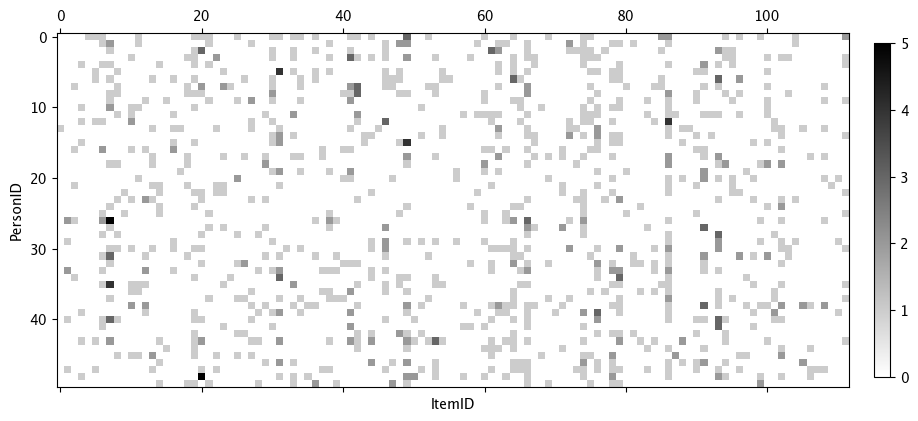

In [20]:
import matplotlib.pyplot as plt
import polars as pl

"""図11.5"""
lda = pl.read_csv("./chap11/input/data-lda.txt")

# pivotを用いてクロス集計する(polarsにはクロス集計機能がないので).
pivot_data = lda.pivot(  # noqa: PD010
    "PersonID",
    "PersonID",
    "ItemID",
    "count",
).fill_null(0)

# pivotしたデータの列を商品番号順にソートする(先頭はPersonID列).
col_names = [pivot_data.columns[0], *sorted(pivot_data.columns[1:], key=int)]
cross_data = pivot_data[col_names]

im = plt.matshow(
    cross_data[:, 1:],
    cmap="binary",
    aspect="equal",
)

plt.colorbar(im, fraction=0.02, pad=0.03)
plt.setp(plt.gca(), xlabel="ItemID", ylabel="PersonID")
plt.show()

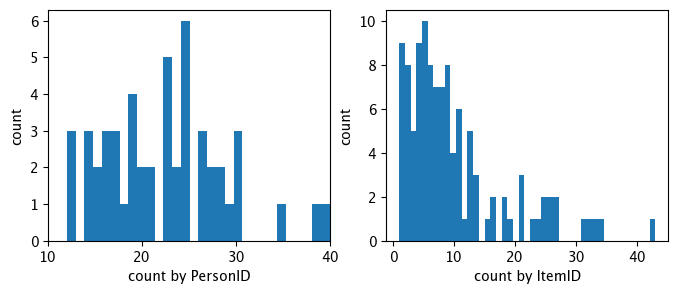

In [29]:
import matplotlib.pyplot as plt
import numpy as np

"""図11.6"""
lda = pl.read_csv("./chap11/input/data-lda.txt")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.hist(lda.group_by("PersonID").count()["count"], bins=30)
plt.setp(
    ax1,
    xticks=np.arange(10, 41, 10),
    xlim=(10, 40),
    xlabel="count by PersonID",
    ylabel="count",
)
ax2.hist(lda.group_by("ItemID").count()["count"], bins=45)
plt.setp(ax2, xlabel="count by ItemID", ylabel="count")
plt.show()

### 11.4.2 メカニズムの想像

顧客数をN＝50，商品数を1＝120として、LDAモデルに基づいたメカニズムを考える。

顧客1人に限ってメカニズムを想像する。
以下のサイコロを用意する。
- 生鮮食品・保存食品・日用品・衣料・健康美容品・飲料のタグが付いた6面サイコロ
  顧客ごとに確率が異なる
- 上記各タグに特化した(6種類の)120面サイコロ(120は全てのタグ全部込みの商品数)
  顧客ごとに共通のサイコロだが、特化したタグごとに、各120個の商品の出現確率は異なる

商品を購入する際には下記の手順で商品を選ぶ
1. 上記の6つのタグ名が書いてある6面サイコ口を振る
2. 1.で出たタグの120面サイコロを振り、出た商品を購入する
3. 新しい商品を購入する際には1.から繰り返す。

![図11.7](./chap11/output/fig11-7.png)
図11.7 LDAの戦略

![図11.8](./chap11/output/fig11-8.png)
図11.8 K面サイコロの例(ここではK=6)

![図11.9](./chap11/output/fig11-9.png)
図11.9 タグごとに特化した形を持つI面サイコロの例(ここではI = 120)

この顧客ごとにある6面サイコロの各面の出現確率を推定することが顧客の特徴を推定することになる。LDAは120個の商品の購買情報から6個の成分のバランスに情報を圧縮するモデルと解釈できる。

さらに、タグに特化した120面サイコロの各面の出現確率も推定する。すると、どの商品が出やすいかでタグを特徴づけることができる。これまでは説明のため、タグの内容を「生鮮食品」などあらかじめ与えたが、本来はその逆である。例えば、推定された出やすいトップ20の商品名から、「このタグは生鮮食品である」と解釈するのだ。

実際にはタグの数は6と決めず、複数試して十分な大きさに指定する。タグの数が少ないと、十分にグループが分割できない。高度なモデル(ノンパラメトリックベイズモデル)[15]においては、このタグの数すらも推定することができるが本書の範囲を超える。

### 11.4.3 モデル式の記述

1人の顧客が1つの商品を購入する場合を考える。n番目の顧客がy番目の商品を購入する場合のメカニズムを指揮にすると以下になる。
$$
\begin{align}
dice &\sim \mathrm{Categorical}(\overrightarrow{\theta[n]}) \nonumber \\
y &\sim \mathrm{Categorical}(\overrightarrow{\phi[dice]}) \nonumber
\end{align}
$$

- $\vec{\theta}$: 長さKのベクトル
- $\vec{\phi}$: 長さIのベクトル

このメカニズムをイラストにすると図11.10となる。

![図11.10](chap11/output/fig11-10.png)
図11.10 n番目の顧客がy番目の商品を購入するメカニズム

この図で、購入商品yに至るルートはK個ある。例えば一番上のルートだと確率は下記となる。他のルートも同様。
$$
\mathrm{Categorical}(1 | \overrightarrow{\theta[n]}) \times \mathrm{Categorical}(y | \overrightarrow{\phi[1]}) = \theta[n, 1] \times \phi[1, y]
$$

それぞれのルートは排他的であるので、n番目の顧客がy番目の商品を購入する確率分布はこれらの確率の和となる。

$$
\begin{align}
p(y|\overrightarrow{\theta[n]}, \overrightarrow{\phi[1]}, \dots, \overrightarrow{\phi[K]})
&= \sum_{k=1}^{K}[\mathrm{Categorical}(k | \overrightarrow{\theta[n]}) \times \mathrm{Categorical}(y | \overrightarrow{\phi[k]})] \nonumber \\
&=\sum_{k=1}^{K}\,[\theta[n, k] \times \phi[k, y]] \nonumber
\end{align}
$$

これはnで決まる一つのK面サイコロ$\overrightarrow{\theta[n]}$と、K個の1面サイコロ$\overrightarrow{\phi[1]}, \ldots, \overrightarrow{\phi[K]}$を与えた時に、$y$を生成する確率分布となっている($y$について和をとると1になる)。この分布を仮にCateCate分布と呼ぶことにしよう。

このCateCate分布を使うと、データファイル11.6を1行ずつ独立に生成するモデル式は以下のように表現できる。

モデル式11-8
$$
ItemID[e] \sim \mathrm{CateCate}(\overrightarrow{\theta[PersonID[e]]}, \overrightarrow{\phi[1]}, \ldots, \overrightarrow{\phi[K]}) \qquad e = 1, \ldots, E
$$

ここで各パラメータは以下である。
- E: 全購入イベント数
- e: イベントのインデックス
- $\overrightarrow{\theta[1]}, \ldots, \overrightarrow{\theta[N]}$: N個のK面サイコロ
- $\overrightarrow{\phi[1]}, \ldots, \overrightarrow{\phi[K]}$: K個のI面サイコロ

この各サイコロの各面の出現確率を推定するが、制約がまったくないとうまく推定できない場合がある。その場合は弱情報事前分布を設定する必要がある([10.2.3項](./chap10.ipynb#1023-確率などの範囲のパラメータ))。

タグ「飲料」の場合、「刺し身」や「唐揚げ」ではなく「お茶」が選ばれやすいように、$\overrightarrow{\phi[k]}$はタグに関連した要素だけが比較的出現確率が高いと考えられるので、ディリクレ分布を$\overrightarrow{\phi[k]}$の事前情報分布として設定するのがよいだろう。

### 11.4.4 Rでシミュレーション

シミュレーションを行い結果を見る。

In [2]:
import numpy as np
import polars as pl

N = 50
I = 120
K = 6

random_gen = np.random.default_rng(123)

alpha0 = np.full(K, 0.8)
alpha1 = np.full(I, 0.2)
theta = random_gen.dirichlet(alpha0, N)
phi = random_gen.dirichlet(alpha1, K)

num_items_by_n = np.round(np.exp(random_gen.normal(2.0, 0.5, N))).astype(int)

d = pl.DataFrame()
for n in range(N):
    z = random_gen.choice(np.arange(K), num_items_by_n[n], replace=True, p=theta[n])
    item = [random_gen.choice(np.arange(I), 1, replace=True, p=phi[k])[0] for k in z]
    d = pl.concat(
        [d, pl.DataFrame({"PersonID": np.repeat(n, len(item)), "ItemID": item})],
    )
d

PersonID,ItemID
i64,i64
0,85
0,110
0,15
0,77
0,15
0,24
0,70
1,31
1,101


### 11.4.5 Stanで実装

モデル11-8の実装例 [model11-8.stan](./chap11/model/model11-8.stan)

このモデルはパラメータの数が多く、Stanの標準の推定アルゴリズムNUTSでは推定に時間がかかるため、ADVI(Automatic Differentiation Variational Inference, 変分ベイズ法の一実装)の機能を利用して推定する。ADVIは事後分布を近似した分布を変分ベイズで求め、最終的にはその分布から乱数サンプルを発生させて返す。

/var/folders/f5/_tj1zvq95fx0wllynn0tpq800000gn/T/ipykernel_93272/4115264421.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs2.tight_layout(fig, rect=[0.6, None, None, None])


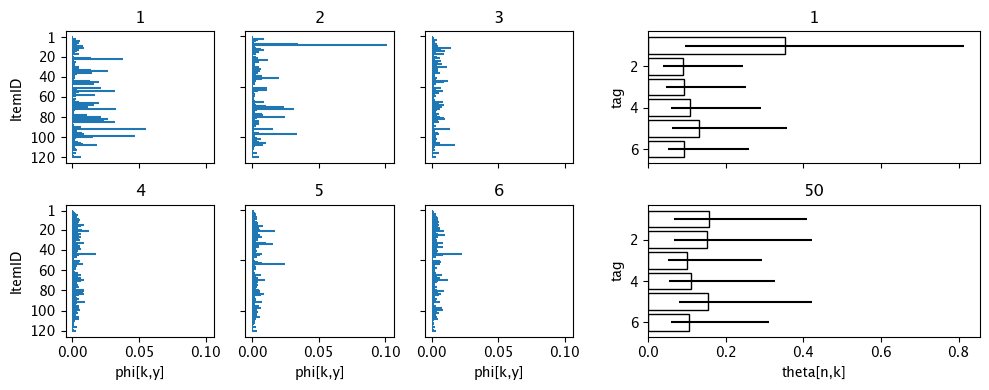

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel
from matplotlib import gridspec

"""ADVIを用いた推定"""
lda = pl.read_csv("./chap11/input/data-lda.txt")
N = 50
I = 120
K = 6
data = {
    "E": lda.shape[0],
    "N": N,
    "I": I,
    "K": K,
    "PersonID": lda["PersonID"].to_list(),
    "ItemID": lda["ItemID"].to_list(),
    "Alpha": np.repeat(0.5, I),
}
sm = CmdStanModel(stan_file="./chap11/model/model11-8.stan")

# NUTS (No U-Turn Sampler) 時間がかかる
# fit_nuts = sm.sample(data=data, seed=123)  # noqa: ERA001

# ADVI (Automatic Differentiation Variational Inference)
fit_vb = sm.variational(data=data, seed=123)

"""図11.11"""
probs = (10, 25, 50, 75, 90)
MCMC_samples = pl.DataFrame(fit_vb.variational_sample_pd)

"""左図"""
idx = np.array([[k + 1, i + 1] for k, i in np.ndindex(K, I)])

sorted_col_name = [f"phi[{k},{i}]" for k, i in idx]
phi = MCMC_samples.select(r"^phi\[.*\]$")
phi = phi[sorted_col_name]
d_qua = np.percentile(phi, probs, axis=0).T
d_qua = pl.DataFrame(
    np.hstack((idx, d_qua)),
    schema=["tag", "item"] + [f"p{p}" for p in probs],
)

fig = plt.figure(figsize=(10, 4))
gs1 = gridspec.GridSpec(2, 3)
ax = None
for i, pos in enumerate(np.ndindex(2, 3)):
    ax = fig.add_subplot(gs1[pos], sharex=ax)
    ax.invert_yaxis()
    ax.hlines("item", 0, "p50", data=d_qua.filter(pl.col("tag") == i + 1))
    if pos[0] == 0:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        plt.setp(ax, xlabel="phi[k,y]")
    if pos[1] == 0:
        plt.setp(ax, yticks=[1, *list(np.arange(20, 121, 20))], ylabel="ItemID")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax, title=i + 1)
gs1.tight_layout(fig, rect=[None, None, 0.6, None])

"""右図"""
idx2 = np.array([[n + 1, k + 1] for n, k in np.ndindex(N, K)])
sorted_col_name2 = [f"theta[{n},{k}]" for n, k in idx2]
theta = MCMC_samples.select(r"^theta\[.*\]$")
theta = theta[sorted_col_name2]

d_qua2 = np.percentile(theta, probs, axis=0).T
d_qua2 = pl.DataFrame(
    np.hstack((idx2, d_qua2)),
    schema=["person", "tag"] + [f"p{p}" for p in probs],
)

gs2 = gridspec.GridSpec(2, 1)
ax = None
for i, person in enumerate([1, 50]):
    ax = fig.add_subplot(gs2[i], sharex=ax)
    ax.invert_yaxis()
    sub = d_qua2.filter(pl.col("person") == person)
    ax.barh(
        "tag",
        "p50",
        data=sub,
        xerr=(sub["p25"], sub["p75"]),
        color="w",
        edgecolor="k",
    )
    if i == 0:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        plt.setp(ax, xlabel="theta[n,k]")
    plt.setp(ax, title=person, ylabel="tag")
gs2.tight_layout(fig, rect=[0.6, None, None, None])

plt.show()

## 補足と文献案内

ゼロ過剰ポアソン分布は、逆にゼロだけ頻度が少ない場合には対応できない。その場合、ハードルモデル(hurdle model)を使用するとよい。例えば、ポアソン分布を使ったハードルモデルはベルヌーイ分布と切断ポアソン分布を混ぜた確率分布。(Stanのマニュアルの「Finite Mixtures」の章を参照)

トピックモデルやその拡張については
- [15] 岩田具治.(2015).トピックモデル.講談社.
- [22] 佐藤一誠.(2015).トピックモデルによる統計的潜在意味解析.コロナ社.

を参照。

## 練習問題

(1)「~」の代わりにtargetを使った記法を使ってmodel8-4b.stanを書き直し、実行せよ。

以下のように書き直す
```diff
 model {
-  a ~ normal(a0, s_a);
-  b ~ normal(b0, s_b);
-  Y ~ normal(a[KID] + b[KID] .* X, s_Y);
+  target += normal_lpdf(a | a0, s_a);
+  target += normal_lpdf(b | b0, s_b);
+  target += normal_lpdf(Y | a[KID] + b[KID] .* X, s_Y);
 }
```

In [25]:
import polars as pl
from cmdstanpy import CmdStanModel

salary2_df = pl.read_csv("./chap08/input/data-salary-2.txt")

data = {
    "N": salary2_df.shape[0],
    "K": salary2_df["KID"].max(),
    "X": salary2_df["X"].to_list(),
    "Y": salary2_df["Y"].to_list(),
    "KID": salary2_df["KID"].to_list(),
}

sm = CmdStanModel(stan_file="./chap11/exercise/ex1.stan")
fit = sm.sample(data=data, seed=1234)

fit.summary()

21:20:55 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/exercise/ex1.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/exercise/ex1
21:21:05 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/exercise/ex1
21:21:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


21:21:06 - cmdstanpy - INFO - CmdStan done processing.
21:21:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 11 divergent transitions (1.1%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-217.58500,0.136214,3.525620,-224.117000,-217.24000,-212.46600,669.92900,899.23300,1.004090
a0,398.12300,14.107500,233.826000,231.914000,371.66400,622.53000,274.71700,368.74700,1.018710
b0,11.73380,0.244176,8.165680,0.756618,12.17700,21.99740,1118.35000,1501.14000,1.001820
a[1],384.09200,0.382202,15.402200,357.921000,384.53000,408.85700,1623.99000,2179.85000,1.005610
a[2],334.25900,0.421346,18.034400,304.630000,333.83000,363.94400,1831.99000,2459.05000,1.002010
a[3],323.09800,0.847296,32.536700,268.429000,323.72900,374.34300,1474.61000,1979.34000,0.999927
a[4],498.80200,5.775960,142.109000,324.554000,471.15900,771.46600,605.33500,812.53100,1.006170
b[1],7.69943,0.024239,0.953712,6.152600,7.68201,9.32272,1548.18000,2078.09000,1.003790
b[2],19.44860,0.031811,1.336770,17.293900,19.46080,21.69580,1765.88000,2370.31000,1.001930
b[3],12.02370,0.041718,1.605120,9.478620,11.99820,14.69990,1480.38000,1987.09000,0.999826


(2) 11.1.2項のベルヌーイ分布（コイントス）の例題において、コインの代わりにサイコロを振って、「1」の目が出た時のみ正直に答えるとしてmodel11-1.stanを修正して実行せよ。ただし、サイコロの各日の出る確率は1/6とする。喫煙する確率の推定された中央値と95%ベイズ信頼区間を答えよ.

修正箇所
```diff
 model {
   for (n in 1:N)
     target += log_sum_exp(
-      log(0.5) + bernoulli_lpmf(Y[n] | q),
-      log(0.5) + bernoulli_lpmf(Y[n] | 1)
+      log(1.0/6) + bernoulli_lpmf(Y[n] | q),
+      log(5.0/6) + bernoulli_lpmf(Y[n] | 1)
     );
 }
```

In [26]:
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル11-1の実行"""
coin_df = pl.read_csv("./chap11/input/data-coin.txt")

data = {
    "N": coin_df.shape[0],
    "Y": coin_df["Y"].to_list(),
}

sm = CmdStanModel(stan_file="./chap11/exercise/ex2.stan")
fit = sm.sample(data=data, seed=1234)

fit.summary(percentiles=(2, 50, 97))

21:25:30 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/exercise/ex2.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/exercise/ex2
21:25:34 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/exercise/ex2
21:25:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:35 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,2%,50%,97%,N_Eff,N_Eff/s,R_hat
lp__,-87.528000,0.023304,0.735785,-90.002900,-87.246300,-87.002700,996.831,5246.48,1.00485
q,0.031715,0.000700,0.030086,0.000811,0.022718,0.106852,1848.180,9727.25,1.00130


(3) 11.1.2項のベルヌーイ布(コイントス)の例題において、コインを2枚投げて両方とも「表」が出た時のみ正直に答えるとする。以下の二つの場合を考え、model11-1.stanを修正して実行せよ。そして、喫煙する確率のの推定された中央値と95％ベイズ信頼区間を答えよ。

  - A) コインのうち1枚は表が出る確率は0.5とし、もう1枚は表が出る確率は0.4とする。
  - B) コインのうち1枚は表が出る確率は0.5とし、もう1枚は表が出る確率はp-coinとし、p-coin の事前分布は無情報事前分布とする。

修正箇所A
```diff
 model {
   for (n in 1:N)
     target += log_sum_exp(
-      log(0.5) + bernoulli_lpmf(Y[n] | q),
-      log(0.5) + bernoulli_lpmf(Y[n] | 1)
+      log(0.2) + bernoulli_lpmf(Y[n] | q),
+      log(0.8) + bernoulli_lpmf(Y[n] | 1)
     );
 }
```

修正箇所B
```diff
 parameters {
-  real<lower=0, upper=1> q;
+  real<lower=0, upper=1> p_coin;
 }

 model {
-  for (n in 1:N)
-    target += log_sum_exp(
-      log(0.5) + bernoulli_lpmf(Y[n] | q),
-      log(0.5) + bernoulli_lpmf(Y[n] | 1)
-    );
+  for (n in 1:N) {
+    vector[3] lp;
+    lp[1] = log(0.5) + log(p_coin) + bernoulli_lpmf(Y[n] | q);
+    lp[2] = log(0.5) + log1m(p_coin) + bernoulli_lpmf(Y[n] | 1);
+    lp[3] = log(0.5) + bernoulli_lpmf(Y[n] | 1);
+    target += log_sum_exp(lp);
+  }
 }
```

In [29]:
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル11-1の実行"""
coin_df = pl.read_csv("./chap11/input/data-coin.txt")

data = {
    "N": coin_df.shape[0],
    "Y": coin_df["Y"].to_list(),
}

sm1 = CmdStanModel(stan_file="./chap11/exercise/ex3_A.stan")
fit1 = sm1.sample(data=data, seed=1234)
print(fit1.summary(percentiles=(2, 50, 97)))  # noqa: T201

sm2 = CmdStanModel(stan_file="./chap11/exercise/ex3_B.stan")
fit2 = sm2.sample(data=data, seed=1234)
print(fit2.summary(percentiles=(2, 50, 97)))  # noqa: T201

22:34:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:34:31 - cmdstanpy - INFO - CmdStan done processing.



           Mean      MCSE    StdDev         2%        50%        97%  \
lp__ -82.602300  0.027769  0.764277 -84.988400 -82.308600 -82.056900   
q      0.035678  0.000806  0.032966   0.000946   0.026202   0.115976   

         N_Eff  N_Eff/s    R_hat  
lp__   757.502  1183.60  1.00932  
q     1674.220  2615.97  1.00338  


22:34:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:34:32 - cmdstanpy - INFO - CmdStan done processing.



             Mean      MCSE    StdDev         2%        50%        97%  \
lp__   -72.925900  0.042922  1.204790 -76.417000 -72.559300 -71.759200   
q        0.131021  0.002331  0.087266   0.004742   0.120102   0.312447   
p_coin   0.871608  0.002454  0.090607   0.659901   0.884809   0.994055   

           N_Eff   N_Eff/s    R_hat  
lp__     787.896   615.063  1.00371  
q       1401.850  1094.340  1.00055  
p_coin  1363.750  1064.600  1.00253  


(4) 以下のモデル式11-9の尤度とモデル式11-10の尤度は等価である。

  モデル式11-9
  $$
  \begin{align}
  m &\sim \mathrm{Poisson}(\lambda) \nonumber \\
  {\vec{Y}} &\sim \mathrm{Multinomial}(m, \vec{p}) \nonumber
  \end{align}
  $$
  
  モデル式11-10
  $$
  Y_{k} \sim \mathrm{Poisson}(\lambda p_{k}) \qquad k = 1, \ldots, K-1
  $$
  
  ここでMultinomialは多項分布であり、$\vec{p}$はK-simplexを表し、$\vec{Y}$は長さ$K$で要素が非負の整数値で合計が$m$となるベクトルを表す。データ$\vec{Y}$から$\lambda$と$\vec{p}$を推定する。$K＝3$の場合について等価であることを証明せよ。\
  (ヒント: $Y_3 = 1 - Y_1 - Y_2,\ p_3 = 1 - p_1 - p_2$であることを利用する)

  証明

$$
\begin{align}
&\sum_{m=0}^\infty \left[
  \mathrm{Poisson}(m|\lambda)
  \times \mathrm{Multinomial}(\vec{Y}|m, \vec{p})
\right] \nonumber \\
&= \sum_{m = 0}^\infty \left[
  \frac{\lambda^m e^{-\lambda}}{m!}
  \times \frac{m!}{Y_1! Y_2! Y_3!} p_1^{Y_1}p_2^{Y_2}p_3^{Y_3}
\right] \nonumber \\
&= \sum_{m = Y_1 + Y_2}^\infty \left[
  \frac{\lambda^m e^{-\lambda}}{m!}
  \times \frac{m!}{Y_1! Y_2! (m - Y_1 - Y_2)!} p_1^{Y_1} p_2^{Y_2} p_3^{m - Y_1 - Y_2}
\right] \nonumber \\
&= \frac{p_1^{Y_1} p_2^{Y_2} e^{-\lambda}}{Y_1! Y_2!}
  \sum_{m = Y_1 + Y_2}^{\infty} \left[
    \frac{\lambda^m}{(m - Y_1 - Y_2)!} p_3^{m - Y_1 - Y_2}
  \right] \nonumber \\
&= \frac{p_1^{Y_1} p_2^{Y_2} e^{-\lambda}}{Y_1! Y_2!}
  \sum_{\xi = 0}^{\infty} \left[
    \frac{\lambda^{\xi + Y_1 + Y_2}}{\xi!} p_3^\xi
  \right] \nonumber \\
&= \frac{(\lambda p_1)^{Y_1} (\lambda p_2)^{Y_2} e^{-\lambda}}{Y_1! Y_2!}
  \sum_{\xi = 0}^{\infty} \left[
    \frac{\lambda^\xi}{\xi!} p_3^\xi
  \right] \nonumber \\
&= \frac{(\lambda p_1)^{Y_1} (\lambda p_2)^{Y_2} e^{-\lambda}}{Y_1! Y_2!} e^{(\lambda p_3)}
 = \frac{(\lambda p_1)^{Y_1}(\lambda p_2)^{Y_2} e^{-\lambda}}{Y_1! Y_2!} e^{\lambda(1 - p_1 - p_2)}
\nonumber \\
&= \frac{(\lambda p_1)^{Y_1} e^{-(\lambda p_1)}}{Y_1!}
   \frac{(\lambda p_2)^{Y_2} e^{-(\lambda p_2)}}{Y_2!} 
\nonumber \\
\end{align}
$$

(5) functionsブロックを利用してmodel11-1.stanを書き直し、実行せよ。

In [28]:
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル11-1の実行"""
coin_df = pl.read_csv("./chap11/input/data-coin.txt")

data = {
    "N": coin_df.shape[0],
    "Y": coin_df["Y"].to_list(),
}

sm = CmdStanModel(stan_file="./chap11/exercise/ex5.stan")
fit = sm.sample(data=data, seed=1234)
fit.summary(percentiles=(2, 50, 97))

22:33:47 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/exercise/ex5.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/exercise/ex5
22:34:03 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap11/exercise/ex5
22:34:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:34:03 - cmdstanpy - INFO - CmdStan done processing.



           Mean      MCSE    StdDev         2%        50%        97%    N_Eff  \
lp__ -69.761200  0.035153  0.938991 -72.600400 -69.399700 -69.080500  713.501   
q      0.198501  0.003089  0.092628   0.026012   0.196153   0.378385  899.432   

      N_Eff/s    R_hat  
lp__  1651.62  1.00091  
q     2082.02  1.00240  


(6) model11-8.stanは、ある人が同じ商品を複数回購入している場合、そのたびにCateCate分布を呼び出し、同じ値の尤度を複数回計算するので効率が悪い。データの渡し方とStanコードを工夫して効率化せよ。\
  (ヒント: R側で商品を購入した回数を集計する)

In [9]:
import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル11-8の実行"""
lda = pl.read_csv("./chap11/input/data-lda.txt")
N = 50
I = 120
K = 6

# 同一人物が同じ商品を重複して買っている回数をカウントしてデータに追加する。重複行は削除する。
lda_with_freq = (
    lda.group_by(["PersonID", "ItemID"], maintain_order=True)
    .count()
    .with_columns(pl.col("count").alias("Freq"))
)

data = {
    "E": lda_with_freq.shape[0],
    "N": N,
    "I": I,
    "K": K,
    "PersonID": lda_with_freq["PersonID"].to_list(),
    "ItemID": lda_with_freq["ItemID"].to_list(),
    "Freq": lda_with_freq["Freq"].to_list(),
    "Alpha": np.repeat(0.5, I),
}

sm = CmdStanModel(stan_file="./chap11/exercise/ex6.stan")
fit_vb = sm.variational(data=data, seed=123)

23:13:03 - cmdstanpy - INFO - Chain [1] start processing
23:13:05 - cmdstanpy - INFO - Chain [1] done processing
